In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import scipy.stats as st
from scipy.integrate import quad
import matplotlib.colors as colors
import time
from tqdm import tqdm as tqdm
%matplotlib inline
plt.style.use('ggplot')

In [2]:
class MultivariateNormal:
    def __init__(self, mu, cov_matrix):
        self.mu = np.array(mu)
        self.cov_matrix = np.array(cov_matrix)
        self.k = len(self.mu)
        self.L = np.linalg.cholesky(self.cov_matrix)

    def pdf(self, X):
        # print(f"mean is: \n {self.mu}")
        # print(f"cov is: \n {self.cov_matrix}")
        det_cov = np.linalg.det(self.cov_matrix)
        inv_cov = np.linalg.inv(self.cov_matrix)
     
        normalization = 1 / ((2 * np.pi) ** (self.k / 2) * np.sqrt(det_cov))
        centered_data = X - self.mu
        M_dist_matrix = centered_data @ inv_cov @ centered_data.T
        if M_dist_matrix.ndim > 1:
            Q = 0.5 * np.diag(M_dist_matrix)
        else:
            Q = 0.5 * M_dist_matrix
        
        
        return normalization * np.exp(-Q)
    
    def log_pdf(self, X):
        
        det_cov = np.linalg.det(self.cov_matrix)
        inv_cov = np.linalg.inv(self.cov_matrix)
        
        normalization = -(0.5 * self.k * np.log(2 * np.pi)) - 0.5 * np.log(det_cov)
        centered_data = X - self.mu
        M_dist_matrix = centered_data @ inv_cov @ centered_data.T
        
        if M_dist_matrix.ndim > 1:
            Q = 0.5 * np.diag(M_dist_matrix)
        else:
            Q = 0.5 * M_dist_matrix
        
        return normalization - Q


    def marginalization(self, i):
        # print(f"########## margin_{i} ##############")
        mu_i = self.mu[i,np.newaxis]
        cov_i = self.cov_matrix[i,i,np.newaxis,np.newaxis]
        return self.__class__(mu_i,cov_i)
    
    
    def conditional(self, i, xfix):
        # print(f"############# condition_{i} ############")
        # print(f'x_{i}_fixed is ={xfix}')
        
        V = np.linalg.inv(self.cov_matrix)
        x_chosen = np.atleast_1d(xfix)
        inv_V_ii = 1 / V[i, i,np.newaxis,np.newaxis]
        V_offdig = np.delete(V,i,axis=-1)[i, np.newaxis]
        mu_given_parameter = np.delete(self.mu,i)
        correction = inv_V_ii @ V_offdig @ (x_chosen - mu_given_parameter)
        mean_conditioned = self.mu[i] - correction
        # print(mean_conditioned)
        return self.__class__(mean_conditioned,inv_V_ii),mean_conditioned
    
    def credible_interval(self,index,X,xfix=None, credible_level=0.95, dx=0.01):
        
        if xfix is None:  # Marginalization case
            mvn_func = self.marginalization(index).pdf
            xmax = X[np.argmax(mvn_func(X))]
            # print(xmax)
            
        else:  # Conditional case
            mvn_func = self.conditional(index, xfix)[0].pdf
            xmax =  X[np.argmax(mvn_func(X))]
            
        i = 0
        while True:
            func = lambda x: mvn_func(x)
            integ, _ = quad(func, xmax - i * dx, xmax + i * dx)
            if integ >= credible_level:
                break
            i += 1
        # print(i)
        return i * dx, integ

   
    def sample(self, nsamples):
        v = np.random.normal(size=(self.k, nsamples))
        return self.mu[:, np.newaxis] + np.dot(self.L, v)
    
    
    def __call__(self, X):
        return self.pdf(X)

    

    def __str__(self):
        return f"MultivariateNormal(mu={self.mu.tolist()}, cov_matrix=\n{self.cov_matrix.tolist()})"


In [3]:
mu = np.array([4, 2])
cov_matrix = np.array([[1.44, -0.702],
              [-0.702, 0.81]])

# np.array([[1.44, -1.],
#               [-1., 0.81]])

# Create a MultivariateNormal instance
mvn = MultivariateNormal(mu, cov_matrix)

# Generate a grid of values for X0 and X1
x0 = np.linspace(0,8, 100)
x1 = np.linspace(-2,6,100)

X0, X1 = np.meshgrid(x0, x1)
positions = np.stack([X0.ravel(), X1.ravel()]).T
Z = mvn.pdf(positions).reshape(X0.shape)


######### Marginalised ##################
mvn_margin_0 = mvn.marginalization(0)
x0 = x0[:,np.newaxis]
m0 = mvn_margin_0(x0)


mvn_margin_1 = mvn.marginalization(1)
x1 = x1[:,np.newaxis]
m1 = mvn_margin_1(x1)

######## Conditional ########################

x1_fix = 1
mvn_cond_0,c0_mean = mvn.conditional(0,x1_fix )
c0 = mvn_cond_0(x0)

x0_fix = 1
mvn_cond_1,c1_mean = mvn.conditional(1,x0_fix)
c1 = mvn_cond_1(x1)

###### Credible Interval #################

CI_x0_margin = mvn.credible_interval(0,x0)
CI_x1_margin = mvn.credible_interval(1,x1)
print(f'Credible interval for X0 marginalised is: {mu[0]} \u00B1 {CI_x0_margin[0]}\n'
      f'Credible interval for X1 marginalised is: {mu[1]} \u00B1 {CI_x1_margin[0]}')

CI_x0_condition = mvn.credible_interval(0,x0,x1_fix)
CI_x1_condition = mvn.credible_interval(1,x1,x0_fix)

print(f'Credible interval for X0 conditioned on x1_fix={x1_fix} is: {c0_mean[0]} ± {CI_x0_condition[0]}\n'
      f'Credible interval for X1 conditioned on x0_fix={x0_fix} is: {c1_mean[0]} ± {CI_x1_condition[0]}')

Credible interval for X0 marginalised is: 4 ± 2.36
Credible interval for X1 marginalised is: 2 ± 1.77
Credible interval for X0 conditioned on x1_fix=1 is: 4.866666666666666 ± 1.79
Credible interval for X1 conditioned on x0_fix=1 is: 3.4624999999999995 ± 1.35


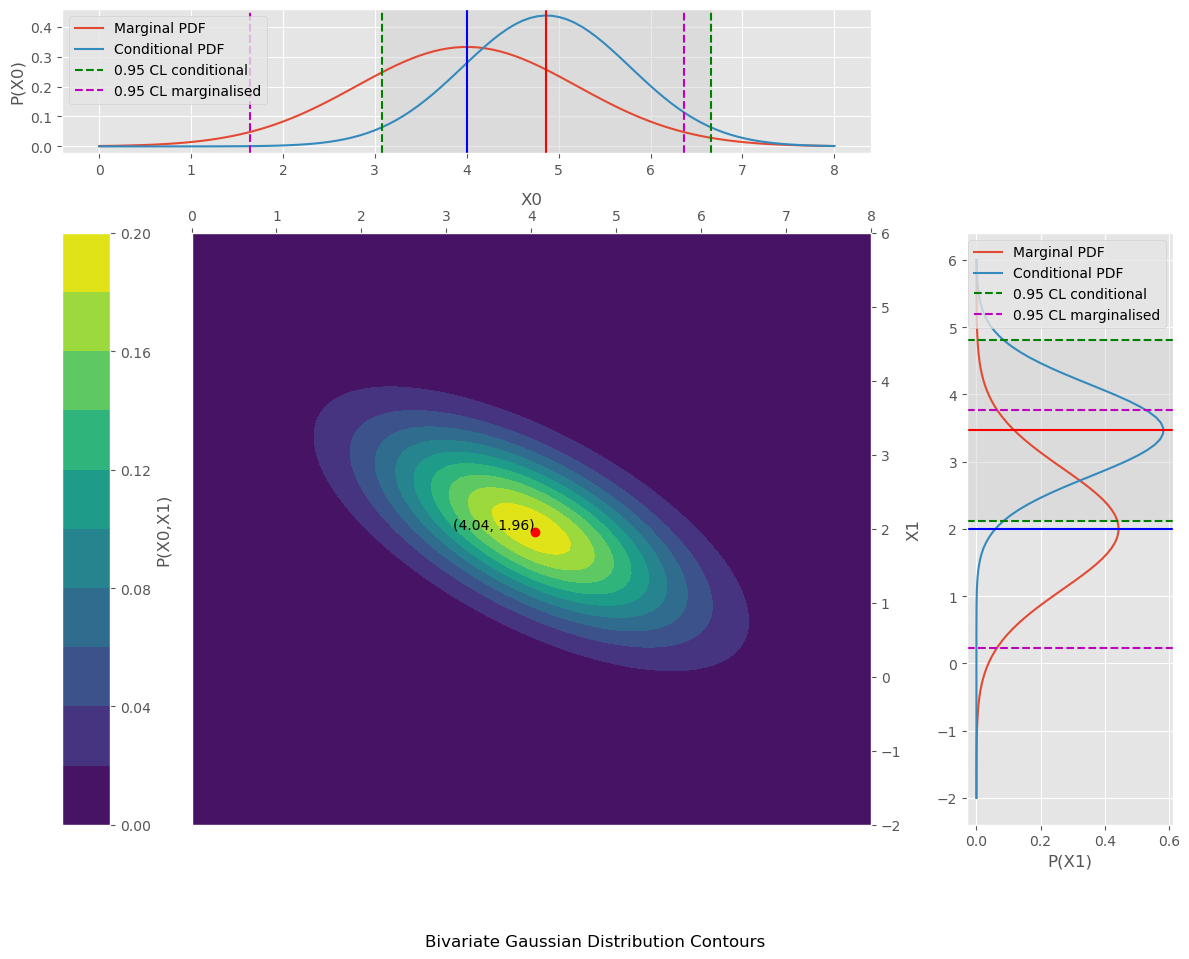

In [4]:
# Creating a subplot grid
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=1, colspan=3)
ax3 = plt.subplot2grid((4, 4), (1, 3), rowspan=3, colspan=1)

# Plotting the bivariate Gaussian distribution contours
contour = ax1.contourf(X0, X1, Z, levels=10, cmap='viridis')
ax1.set_xlabel('X0')
ax1.set_ylabel('X1')
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')

# Adding colorbar 
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("left", size="7%", pad="12%")
cbar1 = fig.colorbar(contour, cax=cax1)
cbar1.set_label('P(X0,X1)')
fig.suptitle('Bivariate Gaussian Distribution Contours', y=-0.02)

# Finding the coordinates of the maximum Z value
max_Z_index = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
max_Z_x0 = x0[max_Z_index[1]]
max_Z_x1 = x1[max_Z_index[0]]

# Plotting the point corresponding to the maximum Z value
ax1.plot(max_Z_x0, max_Z_x1, 'ro', label='Max Z')
ax1.text(max_Z_x0, max_Z_x1, f'({max_Z_x0[0]:.2f}, {max_Z_x1[0]:.2f})', verticalalignment='bottom', horizontalalignment='right')

# Plotting the marginal distribution and conditional distribution of x0 
ax2.plot(x0, m0, label='Marginal PDF')
ax2.plot(x0, c0, label='Conditional PDF')
ax2.axvline(x=c0_mean[0], color='r', linestyle='-')#, label='Conditional Mean')
ax2.axvline(x=c0_mean[0] + CI_x0_condition[0], color='g', linestyle='--',label = '0.95 CL conditional')#, label='Upper CI')
ax2.axvline(x=c0_mean[0] - CI_x0_condition[0], color='g', linestyle='--')
ax2.axvspan(c0_mean[0] - CI_x0_condition[0], c0_mean[0] + CI_x0_condition[0], color='lightgray', alpha=0.5)
ax2.axvline(x=mu[0], color='b', linestyle='-')#, label='Marginal Mean')
ax2.axvline(x=mu[0] + CI_x0_margin[0], color='m', linestyle='--',label = '0.95 CL marginalised')#, label='Marginal Upper CI')
ax2.axvline(x=mu[0] - CI_x0_margin[0], color='m', linestyle='--')#, label='Marginal Lower CI')
ax2.legend()
ax2.set_ylim(ax2.get_ylim())
ax2.set_ylabel('P(X0)')

# Plotting the marginal distribution and conditional distribution of x1
ax3.plot(m1, x1, label='Marginal PDF')
ax3.plot(c1, x1, label='Conditional PDF')
ax3.axhline(y=c1_mean[0], color='r', linestyle='-')#, label='Conditional Mean')
ax3.axhline(y=c1_mean[0] + CI_x1_condition[0], color='g', linestyle='--',label = '0.95 CL conditional')#, label='Upper CI')
ax3.axhline(y=c1_mean[0] - CI_x1_condition[0], color='g', linestyle='--')
ax3.axhspan(c1_mean[0] - CI_x1_condition[0], c1_mean[0] + CI_x1_condition[0], color='lightgray', alpha=0.5)
ax3.axhline(y=mu[1], color='b', linestyle='-')#, label='Marginal Mean')
ax3.axhline(y=mu[1] + CI_x1_margin[0], color='m', linestyle='--',label = '0.95 CL marginalised')#, label='Marginal Upper CI')
ax3.axhline(y=mu[1] - CI_x1_margin[0], color='m', linestyle='--')#, label='Marginal Lower CI')
ax3.legend()
ax3.set_xlim(ax3.get_xlim())
ax3.set_xlabel('P(X1)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## A. Direct Sampling

In [5]:
nsamples = 30000
samples = mvn.sample(nsamples) # samples[0]is marginalised with x1 and sample[1] with x0 
conditioned_sample_0 = mvn_cond_0.sample(nsamples).flatten()
conditioned_sample_1 = mvn_cond_1.sample(nsamples).flatten()


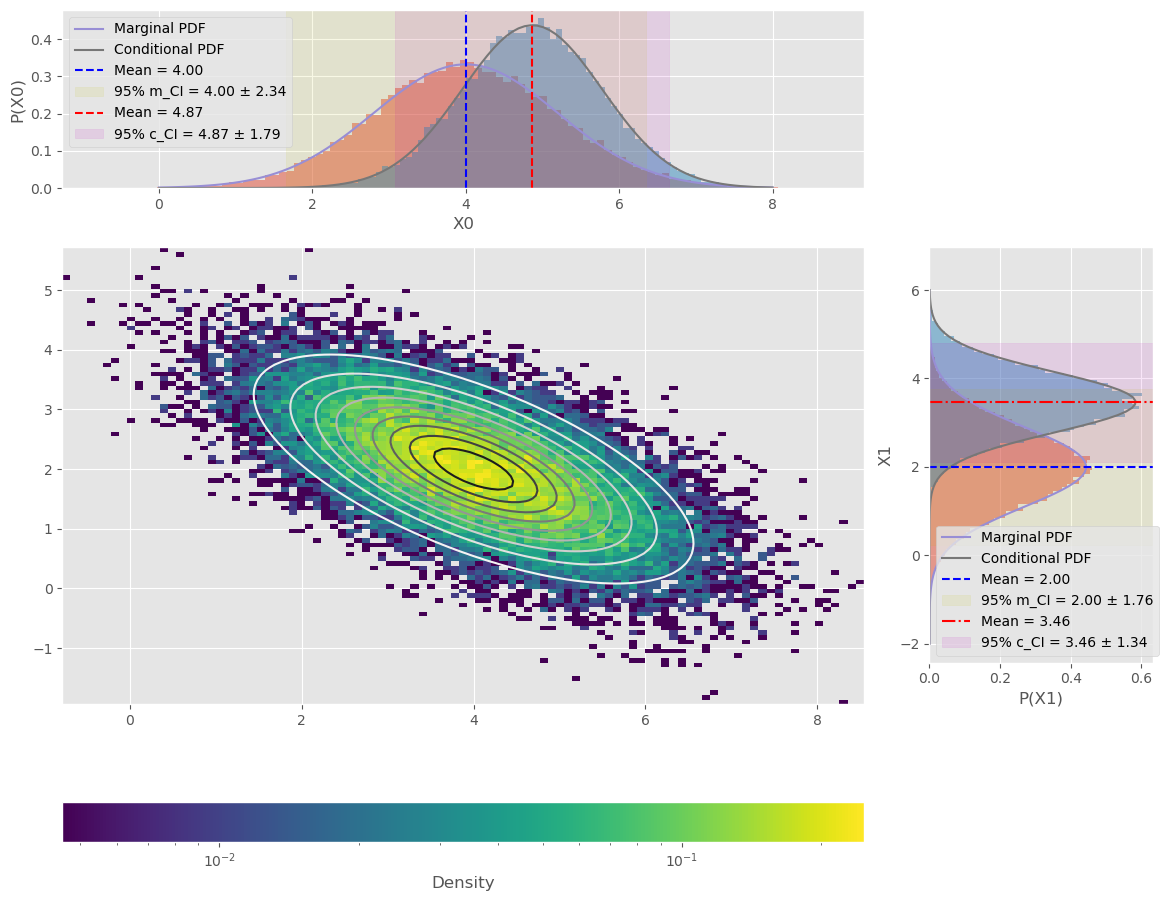

In [6]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((4, 4), (1, 0), rowspan=4, colspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=1, colspan=3)
ax3 = plt.subplot2grid((4, 4), (1, 3), rowspan=2, colspan=1)

# Define bins
bin0 = np.linspace(min(samples[0]), max(samples[0]), num=100)
bin1 = np.linspace(min(samples[1]), max(samples[1]), num=100)
c_bin0 = np.linspace(min(conditioned_sample_0), max(conditioned_sample_0), num=100)
c_bin1 = np.linspace(min(conditioned_sample_1), max(conditioned_sample_1), num=100)

# Plot hist2d
h = ax1.hist2d(samples[0], samples[1], bins=(bin0, bin1), norm=colors.LogNorm(), density=True)
ax1.contour(X0, X1, Z, levels=10, cmap='Greys')
cbar = fig.colorbar(h[3], ax=ax1,orientation='horizontal')#, location='bottom')
cbar.set_label('Density')

# Plot histograms for P(X0)
mean_m0 = np.mean(samples[0])
cl_m0 = 1.96 * np.std(samples[0])
mean_c0 = np.mean(conditioned_sample_0)
cl_c0 = 1.96 * np.std(conditioned_sample_0)

hist0, _, _ = ax2.hist(samples[0], bins=bin0, density=True,alpha = 0.5)
histcond0, _, _ = ax2.hist(conditioned_sample_0,bins = c_bin0, density=True,alpha = 0.5)

ax2.plot(x0, m0, label='Marginal PDF')
ax2.plot(x0, c0, label='Conditional PDF')
ax2.axvline(mean_m0, color='b', linestyle='--', label=f'Mean = {mean_m0:.2f}')
ax2.axvspan(mean_m0 - cl_m0, mean_m0 + cl_m0, alpha=0.1, color='y', label=f'95% m_CI = {mean_m0:.2f} ± {cl_m0:.2f}')
ax2.axvline(mean_c0, color='r', linestyle='--', label=f'Mean = {mean_c0:.2f}')
ax2.axvspan(mean_c0 - cl_c0, mean_c0 + cl_c0, alpha=0.1, color='m', label=f'95% c_CI = {mean_c0:.2f} ± {cl_c0:.2f}')
ax2.set_ylabel('P(X0)')
ax2.set_xlabel('X0')

# Plot histograms for P(X1)
mean_m1 = np.mean(samples[1])
cl_m1 = 1.96 * np.std(samples[1])
mean_c1 = np.mean(conditioned_sample_1)
cl_c1 = 1.96 * np.std(conditioned_sample_1)

hist1, _, _ = ax3.hist(samples[1], bins=bin1, orientation='horizontal', density=True,alpha = 0.5)
histcond1, _, _ = ax3.hist(conditioned_sample_1,bins = c_bin1, orientation='horizontal', density=True,alpha = 0.5)

ax3.plot(m1, x1, label='Marginal PDF')
ax3.plot(c1, x1, label='Conditional PDF')
ax3.axhline(mean_m1, color='b', linestyle='--', label=f'Mean = {mean_m1:.2f}')
ax3.axhspan(mean_m1 - cl_m1, mean_m1 + cl_m1, alpha=0.1, color='y', label=f'95% m_CI = {mean_m1:.2f} ± {cl_m1:.2f}')
ax3.axhline(mean_c1, color='r', linestyle='-.', label=f'Mean = {mean_c1:.2f}')
ax3.axhspan(mean_c1 - cl_c1, mean_c1 + cl_c1, alpha=0.1, color='m', label=f'95% c_CI = {mean_c1:.2f} ± {cl_c1:.2f}')
ax3.set_xlabel('P(X1)')
ax3.set_ylabel('X1')




# Add legend
ax2.legend()
ax3.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

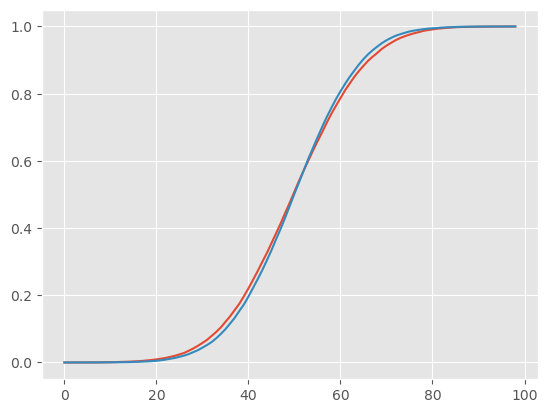

In [7]:
t0 = np.cumsum(hist0*np.diff(bin0))
t1 = np.cumsum(hist1*np.diff(bin1))
plt.plot(t0)
plt.plot(t1)


In [8]:
def CL_95(hist,bin):
    # Find the cumulative sum of histograms
    cumulative_sum_x = np.cumsum(hist * np.diff(bin))
   # Find the indices for 2.5% and 97.5% probability mass
    x_min_index = np.argmax(cumulative_sum_x >= 0.025)
    x_max_index = np.argmax(cumulative_sum_x >= 0.975)
   
    # Calculate the 95% probability mass range
    x_min = bin[x_min_index]
    x_max = bin[x_max_index]
   
  
    return x_min,x_max

lower_value_x0, upper_value_x0 = CL_95(hist0, bin0)
lower_value_x1, upper_value_x1 = CL_95(hist1, bin1)
lower_value_c0, upper_value_c0 = CL_95(histcond0, c_bin0)
lower_value_c1, upper_value_c1 = CL_95(histcond1, c_bin1)




# Plot

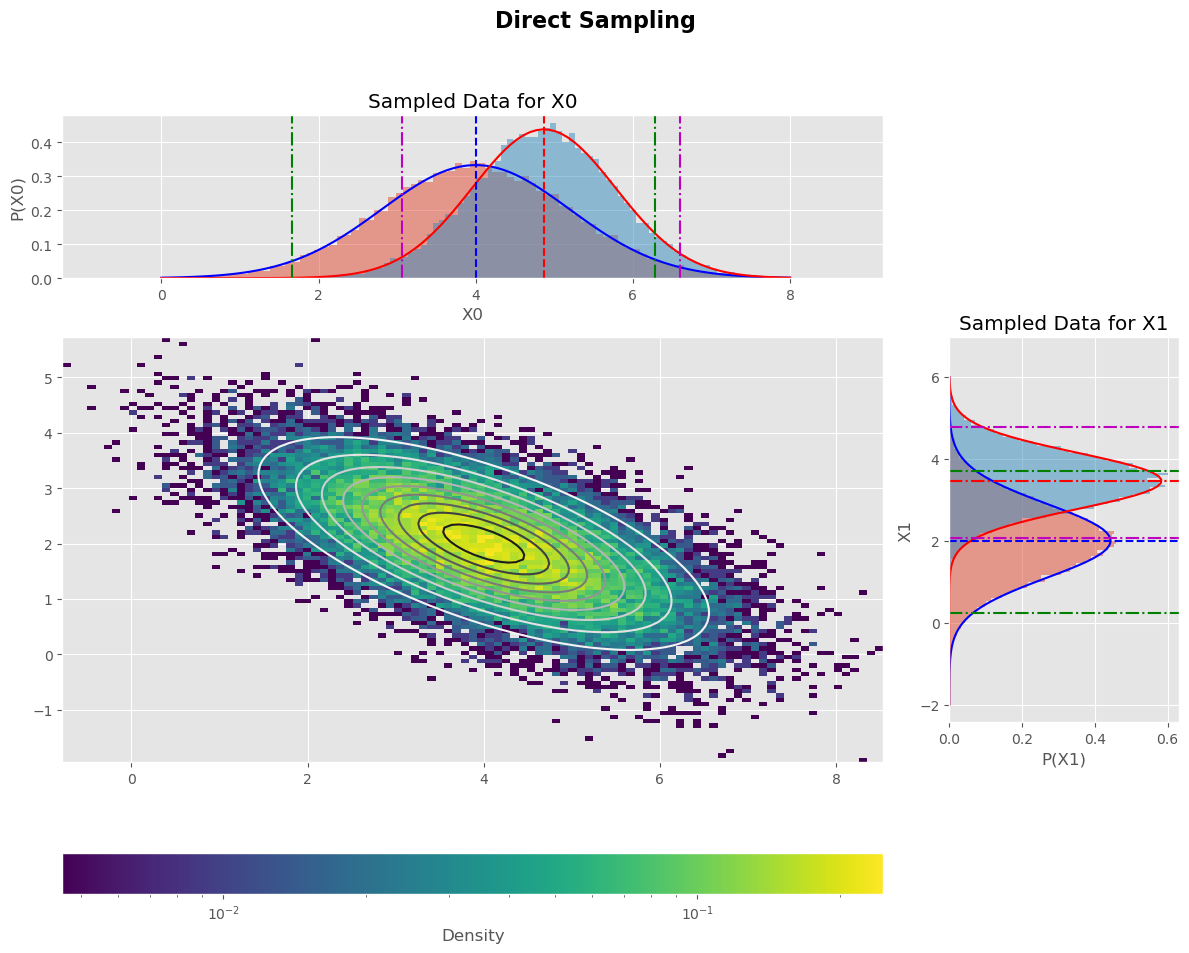

95% range for P(X0): 1.6645104443807375 to 6.278646013402723
95% range for P(X1): 0.22502671350111347 to 3.70605078134414
95% range for conditional P(X0): 3.0624754354188557 to 6.59395123760881
95% range for conditional P(X1): 2.076798640697165 to 4.778007707266669


In [9]:

fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((4, 4), (1, 0), rowspan=4, colspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=1, colspan=3)
ax3 = plt.subplot2grid((4, 4), (1, 3), rowspan=2, colspan=1)

# Define bins
bin0 = np.linspace(min(samples[0]), max(samples[0]), num=100)
bin1 = np.linspace(min(samples[1]), max(samples[1]), num=100)
c_bin0 = np.linspace(min(conditioned_sample_0), max(conditioned_sample_0), num=100)
c_bin1 = np.linspace(min(conditioned_sample_1), max(conditioned_sample_1), num=100)

plt.suptitle('Direct Sampling', fontsize=16, fontweight='bold')

# Plot hist2d
h = ax1.hist2d(samples[0], samples[1], bins=(bin0, bin1), norm=colors.LogNorm(), density=True)
ax1.contour(X0, X1, Z, levels=10, cmap='Greys')
cbar = fig.colorbar(h[3], ax=ax1,orientation='horizontal')#, location='bottom')
cbar.set_label('Density')

# Plot histograms for P(X0)
mean_m0 = np.mean(samples[0])
cl_m0 = 2 * np.std(samples[0])
mean_c0 = np.mean(conditioned_sample_0)
cl_c0 = 2 * np.std(conditioned_sample_0)

hist0, _, _ = ax2.hist(samples[0], bins=bin0, density=True,alpha = 0.5)
histcond0, _, _ = ax2.hist(conditioned_sample_0,bins = c_bin0, density=True,alpha = 0.5)

ax2.plot(x0, m0, label='Marginal PDF',color ="b")
ax2.plot(x0, c0, label='Conditional PDF',color ='r')
ax2.axvline(mean_m0, color='b', linestyle='--', label=f'Mean = {mean_m0:.2f}')
# ax2.axvspan(mean_m0 - cl_m0, mean_m0 + cl_m0, alpha=0.1, color='y', label=f'95% m_CI = {mean_m0:.2f} ± {cl_m0:.2f}')
ax2.axvline(mean_c0, color='r', linestyle='--', label=f'Mean = {mean_c0:.2f}')
# ax2.axvspan(mean_c0 - cl_c0, mean_c0 + cl_c0, alpha=0.1, color='m', label=f'95% c_CI = {mean_c0:.2f} ± {cl_c0:.2f}')

# Add lines indicating 95% range for P(X0)
lower_value_xm0, upper_value_xm0 = CL_95(hist0, bin0)
lower_value_xc0, upper_value_xc0 = CL_95(histcond0, c_bin0)
ax2.axvline(lower_value_xm0, color='g', linestyle='-.', label=f'95% Range: {lower_value_xm0:.2f} to {upper_value_xm0:.2f}')
ax2.axvline(lower_value_xc0, color='m', linestyle='-.', label=f'95% Range: {lower_value_xc0:.2f} to {upper_value_xc0:.2f}')
ax2.axvline(upper_value_xm0, color='g', linestyle='-.')
ax2.axvline(upper_value_xc0, color='m', linestyle='-.')
ax2.set_ylabel('P(X0)')
ax2.set_xlabel('X0')
ax2.set_title('Sampled Data for X0')
# Plot histograms for P(X1)
mean_m1 = np.mean(samples[1])
cl_m1 = 2 * np.std(samples[1])
mean_c1 = np.mean(conditioned_sample_1)
cl_c1 = 2 * np.std(conditioned_sample_1)

hist1, _, _ = ax3.hist(samples[1], bins=bin1, orientation='horizontal', density=True,alpha = 0.5)
histcond1, _, _ = ax3.hist(conditioned_sample_1,bins = c_bin1, orientation='horizontal', density=True,alpha = 0.5)

ax3.plot(m1, x1, label='Marginal PDF',color ='b')
ax3.plot(c1, x1, label='Conditional PDF',color ='r')
ax3.axhline(mean_m1, color='b', linestyle='--', label=f'Mean = {mean_m1:.2f}')
# ax3.axhspan(mean_m1 - cl_m1, mean_m1 + cl_m1, alpha=0.1, color='y', label=f'95% m_CI = {mean_m1:.2f} ± {cl_m1:.2f}')
ax3.axhline(mean_c1, color='r', linestyle='-.', label=f'Mean = {mean_c1:.2f}')
# ax3.axhspan(mean_c1 - cl_c1, mean_c1 + cl_c1, alpha=0.1, color='m', label=f'95% c_CI = {mean_c1:.2f} ± {cl_c1:.2f}')

# Add lines indicating 95% range for P(X1)
lower_value_xm1, upper_value_xm1 = CL_95(hist1, bin1)
lower_value_xc1, upper_value_xc1 = CL_95(histcond1, c_bin1)
ax3.axhline(lower_value_xm1, color='g', linestyle='-.', label=f'95% Range: {lower_value_xm1:.2f} to {upper_value_xm1:.2f}')
ax3.axhline(lower_value_xc1, color='m', linestyle='-.', label=f'95% Range: {lower_value_xc1:.2f} to {upper_value_xc1:.2f}')
ax3.axhline(upper_value_xm1, color='g', linestyle='-.')
ax3.axhline(upper_value_xc1, color='m', linestyle='-.')
ax3.set_xlabel('P(X1)')
ax3.set_ylabel('X1')
ax3.set_title('Sampled Data for X1')
# Add legend
# ax2.legend()
# ax3.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("95% range for P(X0):", lower_value_xm0, "to", upper_value_xm0)
print("95% range for P(X1):", lower_value_xm1, "to", upper_value_xm1)
print("95% range for conditional P(X0):", lower_value_xc0, "to", upper_value_xc0)
print("95% range for conditional P(X1):", lower_value_xc1, "to", upper_value_xc1)

# MCMC Sampling

In [10]:
def MH_sampling(X_i, target_distribution, Q_cov_matrix, num_samples, burn_in):
    """
    Perform Metropolis-Hastings sampling with burn-in phase.
    
    Parameters:
        X_i: numpy array, initial sample to start the sampling process.
        target_distribution: MultivariateNormal instance, represents the target distribution.
        Q_cov_matrix: numpy array, covariance matrix for the proposal distribution.
        num_samples: int, number of samples to generate.
        burn_in: int, number of initial samples to discard as burn-in phase.
    
    Returns:
        samples: numpy array, array containing the generated samples.

    Example:
        initial_sample = np.array([0, 0])
        Q_cov_matrix = np.array([[0.5, 0.],
                                  [0., 0.5]])
        num_samples = 30000
        burn_in = 5000  # Define burn-in phase length
        samples = MH_sampling(initial_sample, mvn, Q_cov_matrix, num_samples, burn_in)
    """
    samples = [X_i]  # Store the initial sample in samples list
    
    with tqdm(total=num_samples, desc='Sampling Progress (MH)') as progress_bar:
        while len(samples) < num_samples:  
            X_t = np.random.multivariate_normal(samples[-1], Q_cov_matrix)
            
            # Calculate the acceptance probability
            a = min(1, (target_distribution.pdf(X_t) / target_distribution.pdf(samples[-1])))
            
            if np.random.uniform(0, 1) < a:  # Accept the proposed sample
                samples.append(X_t.copy())
            
            progress_bar.update(1)  # Update the progress bar
    
    return np.array(samples)[burn_in:]  # Discard initial samples as burn-in phase


def gibbs_sampling(mvn, initial_sample, num_samples, burn_in=0):
    """
    Perform Gibbs sampling to generate samples from a multivariate normal distribution.

    Parameters:
        mvn (MultivariateNormal): An instance of MultivariateNormal representing the multivariate normal distribution.
        initial_sample (list): The initial sample for the Gibbs sampling process.
        num_samples (int): The total number of samples to generate.
        burn_in (int, optional): The number of initial samples to discard as burn-in. Defaults to 0.

    Returns:
        list: A list of samples obtained from the Gibbs sampling process.

    Example:
        initial_sample = [1, 1]
        num_samples = 10
        burn_in = 2
        samples = gibbs_sampling(mvn, initial_sample, num_samples, burn_in)
        print(samples)
    """
    samples = [initial_sample]
    xint_fix0, xint_fix1 = initial_sample

    with tqdm(total=num_samples, desc='Sampling Progress (Gibbs)') as progress_bar:
        while len(samples) < num_samples:  # Start from 1, as we already have the initial sample
            # Generating sample for x0_t using the conditional distribution of x0 given x1
            x0_t = mvn.conditional(0, xint_fix1)[0].sample(1).flatten()

            # Generate sample for x1_t using the conditional distribution of x1 given x0
            x1_t = mvn.conditional(1, x0_t)[0].sample(1).flatten()

            # Update the fixed values for the next iteration
            xint_fix0, xint_fix1 = x0_t[0], x1_t[0]

            # Append the new sample
            samples.append([xint_fix0, xint_fix1])

            progress_bar.update(1)  # Update the progress bar
    
    return np.array(samples)[burn_in:]

In [11]:
start_time = time.time()
initial_sample = np.array([0, 0])
Q_cov_matrix = np.array([[0.5, 0.],
                          [0., 0.5]])
num_iteration = 300000
burn_in = 0  
# M-H sampling:
Mh_samples = MH_sampling(initial_sample, mvn, Q_cov_matrix, num_iteration, burn_in)
# Gibbs Sampling
gibbs_samples = gibbs_sampling(mvn, initial_sample, num_iteration, burn_in)
end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate the total time
    
print("Total time taken:", total_time)

Sampling Progress (MH): 498496it [00:49, 10137.74it/s]                            
Sampling Progress (Gibbs): 100%|█████████▉| 299999/300000 [00:19<00:00, 15308.18it/s]

Total time taken: 69.08503651618958


In [12]:
def plot_samples(samples, title):
    bin0 = np.linspace(min(samples[:, 0]), max(samples[:, 0]), num=1000)
    bin1 = np.linspace(min(samples[:, 1]), max(samples[:, 1]), num=1000)
    

    fig = plt.figure(figsize=(12, 10))
    ax1 = plt.subplot2grid((4, 4), (1, 0), rowspan=4, colspan=3)
    ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=1, colspan=3)
    ax3 = plt.subplot2grid((4, 4), (1, 3), rowspan=2, colspan=1)

    plt.suptitle(title, fontsize=16, fontweight='bold')

    # Plot scatter plot of sampled data
    ax1.contour(X0, X1, Z, levels=10, cmap='Greys')
    ax1.scatter(samples[:, 0], samples[:, 1], color='tan', alpha=0.3)
    ax1.set_xlabel('X0')
    ax1.set_ylabel('X1')
    ax1.set_title('Scatter Plot of Sampled Data')

    # Plot histogram for dimension x0
    ax2.plot(x0, m0, label='Marginal PDF',color ="b")
    hist0, _, _ = ax2.hist(samples[:, 0], bins=bin0, color='skyblue', edgecolor='white', alpha=0.7, density=True)
    ax2.set_xlabel('X0')
    ax2.set_ylabel('P(X0)')
    ax2.set_title('Sampled Data for X0')
    
    mean_x0 = np.mean(samples[:, 0])
    ax2.axvline(mean_x0, color='r', linestyle='--')
    ax2.annotate(f'Mean: {mean_x0:.2f}', xy=(mean_x0, 0), xytext=(mean_x0, 0.1),
                arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='black')

    # Plot histogram for dimension x1
    ax3.plot(m1, x1, label='Marginal PDF',color ='r')
    hist1, _, _ = ax3.hist(samples[:, 1], bins=bin1, color='salmon', edgecolor='white', alpha=0.7, density=True, orientation='horizontal')
    ax3.set_xlabel('P(X1)')
    ax3.set_ylabel('X1')
    ax3.set_title('Sampled Data for X1')
    
    mean_x1 = np.mean(samples[:, 1])
    ax3.axhline(mean_x1, color='b', linestyle='--')
    ax3.annotate(f'Mean: {mean_x1:.2f}', xy=(0, mean_x1), xytext=(0.1, mean_x1),
                arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='black')
    
    # Credible interval x0
    lower_value_x0, upper_value_x0 = CL_95(hist0, bin0)
    ax2.axvline(lower_value_x0, color='g', linestyle='-.', label=f'95% Range: {lower_value_x0:.2f} to {upper_value_x0:.2f}')
    ax2.axvline(upper_value_x0, color='g', linestyle='-.')
  
    
    # Credible interval x1
    lower_value_x1, upper_value_x1 = CL_95(hist1, bin1)
    ax3.axhline(lower_value_x1, color='g', linestyle='-.', label=f'95% Range: {lower_value_x1:.2f} to {upper_value_x1:.2f}')
    ax3.axhline(upper_value_x1, color='g', linestyle='-.')
   
    ax2.legend()
    ax3.legend()
    plt.tight_layout()
    plt.show()



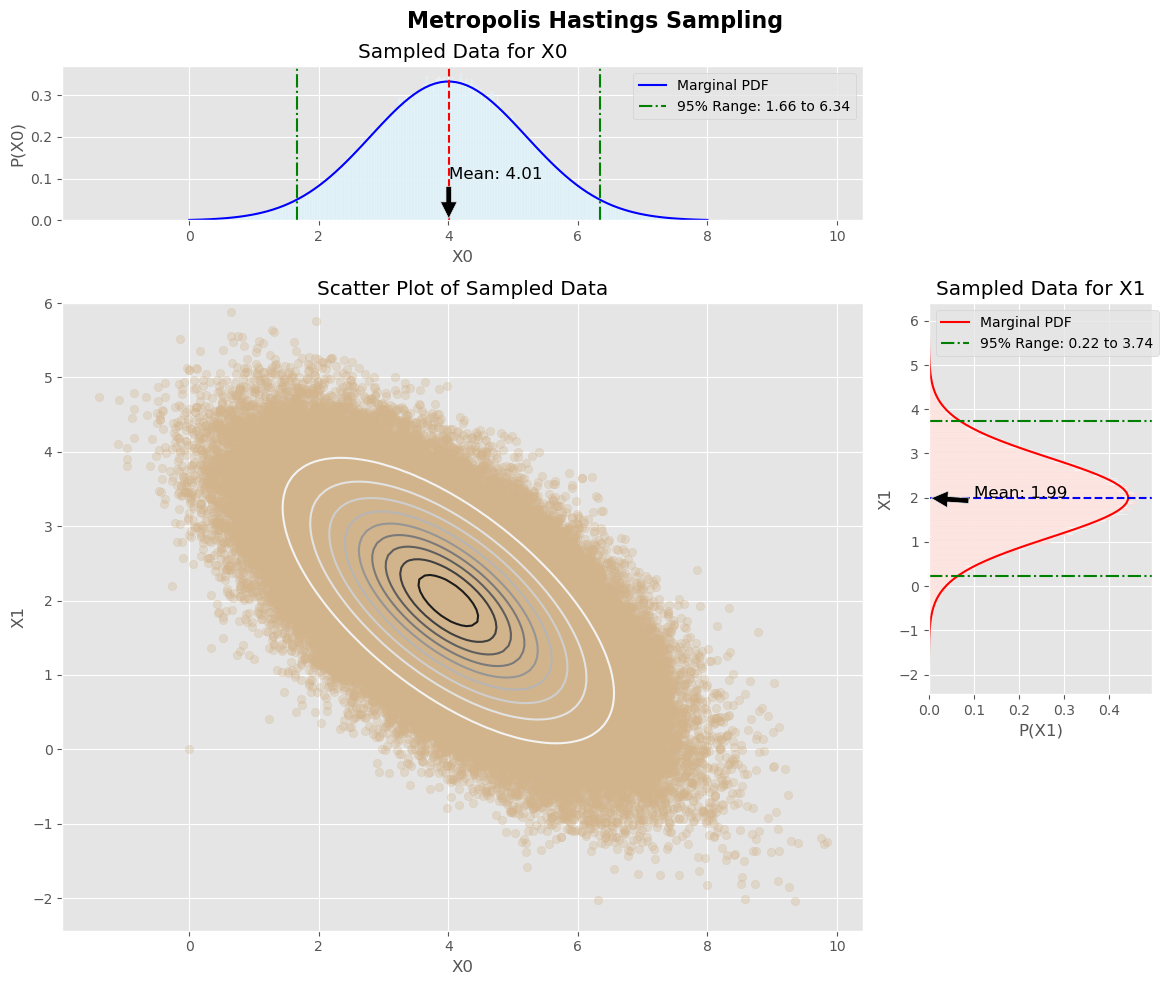

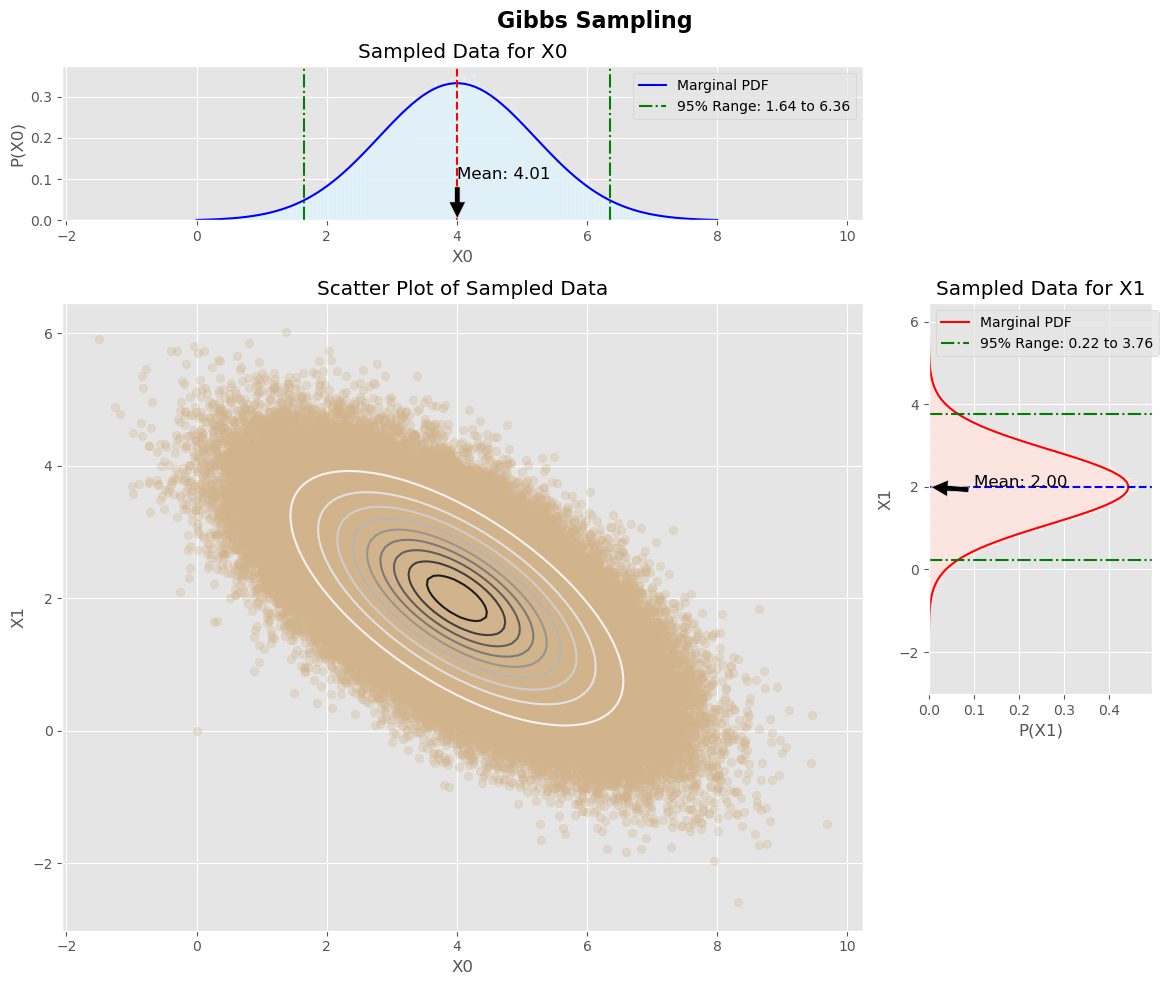

In [13]:
# Usage 
plot_samples(Mh_samples, 'Metropolis Hastings Sampling')
plot_samples(gibbs_samples, 'Gibbs Sampling')


# For Different Chains

# Trace of Negative Log Posterior

### Formula:
The trace of the negative log posterior, denoted as $\text{Tr}[-\log P]$, is calculated as:

$
\text{Tr}[-\log P](k) = -\sum_{m=1}^{M} \frac{1}{m} \log P(x^{(m)}_J | d)
$

- $M$ is the total number of MCMC samples.
- $m$ is the index of each MCMC sample.
- $x^{(m)}_J$ represents the $m_{th}$ sample from the $J_{th}$ chain.
- $P(x^{(m)}_J | d)$ is the posterior probability of the $m_{th}$ sample from the $J_{th}$ chain given the data $d$.
- The sum is over all $M$ MCMC samples from the $J_{th}$ chain.
- The negative log posterior is averaged over all samples to obtain the trace.


The trace of the negative log posterior aevaluates how well the MCMC samples explore the posterior distribution and assess the convergence of Markov Chain Monte Carlo chains. 

- For each chain $J$, the negative log posterior is calculated for each MCMC sample $x^{(m)}_J$.
- The negative log posterior measures the discrepancy between the observed data and the model predictions given the sampled parameters.
- By taking the average over all MCMC samples, the trace provides an indication of how the chain converges to the posterior distribution.
- A stable trace indicates convergence, implying that the MCMC chain has explored the posterior adequately.


In [19]:
def trace_negative_log_posterior(samples, target_distribution):
    """
    Calculate the trace of the negative log posterior given MCMC samples.

    Parameters:
        mvn: MultivariateNormal instance representing the posterior distribution.
        samples: numpy array, MCMC samples.

    Returns:
        trace_values: list, containing the trace values at each sample index.

    Example:
        mvn = MultivariateNormal(mu, cov_matrix)  # Create an instance of MultivariateNormal
        samples = [sample1, sample2, ..., sampleM]  # Provide MCMC samples
        trace_values = trace_negative_log_posterior(mvn, samples)  # Calculate the trace
        print(trace_values)  # Print the trace values
    """
    trace_values = []
    M = len(samples)
    trace = 0.0

    for n in tqdm(range(1,M)):
        log_posterior_prob = target_distribution.log_pdf(samples[n])
        trace += log_posterior_prob / (n)
        trace_values.append(-trace)  # Append the negative of the sum as trace at each sample

    return trace_values


In [20]:
num_chains = 3  # Number of chains
num_samples_per_chain = 30000  # Number of samples per chain
burn_in = 0  # Burn-in period
Q_cov_matrix = np.array([[0.5, 0.],
                          [0., 0.5]])
# Create an empty list to store samples for each chain
mh_samples_list = []
gibbs_samples_list = []

# Run sampling for each chain
for i in range(num_chains):
    # Initialize different initial samples for each chain
    initial_sample = np.random.uniform(-5, 5, size=(2,))

    # M-H sampling
    Mh_samples = MH_sampling(initial_sample, mvn, Q_cov_matrix, num_samples_per_chain, burn_in)
    mh_samples_list.append(Mh_samples)
    

    # Gibbs sampling
    gibbs_samples = gibbs_sampling(mvn, initial_sample, num_samples_per_chain, burn_in)
    gibbs_samples_list.append(gibbs_samples)




Sampling Progress (MH): 49856it [00:04, 10221.56it/s]                           
Sampling Progress (Gibbs): 100%|█████████▉| 29999/30000 [00:01<00:00, 15811.00it/s]
Sampling Progress (MH): 50039it [00:04, 10124.76it/s]                           
Sampling Progress (Gibbs): 100%|█████████▉| 29999/30000 [00:02<00:00, 14671.67it/s]
Sampling Progress (MH): 49941it [00:04, 10285.11it/s]                           
Sampling Progress (Gibbs): 100%|█████████▉| 29999/30000 [00:01<00:00, 16070.57it/s]


In [21]:
mh_trace_list = []
gibbs_trace_list = []
for i in range(num_chains):
    # Calculate trace for M-H sampling
    mh_trace = trace_negative_log_posterior(mh_samples_list[i], mvn)
    mh_trace_list.append(mh_trace)
    # Calculate trace for Gibbs sampling
    gibbs_trace = trace_negative_log_posterior(gibbs_samples_list[i], mvn)
    gibbs_trace_list.append(gibbs_trace)

100%|██████████| 29999/29999 [00:00<00:00, 73717.32it/s]


In [22]:
def plot_samples_chains(samples_list, trace_list, title, markers=None, colors=None):
    
    fig = plt.figure(figsize=(16, 16))  # Increase figsize for larger trace plot

    # Plot scatter plot of sampled data and trace
    ax1 = plt.subplot2grid((5, num_chains), (1, 0), rowspan=3, colspan=num_chains - 1)
    ax2 = plt.subplot2grid((5, num_chains), (0, 0), rowspan=1, colspan=num_chains - 1)
    ax3 = plt.subplot2grid((5, num_chains), (1, num_chains - 1), rowspan=3, colspan=1) 
    ax4 = plt.subplot2grid((5, num_chains), (4, 0), rowspan=1, colspan=num_chains)  

    plt.suptitle(title, fontsize=16, fontweight='bold')

    # Plot scatter plot of sampled data
    ax1.contour(X0, X1, Z, levels=10, cmap='Greys')
    legend_handles = []  # List to store legend handles for scatter plot
    for i, (samples, marker, color) in enumerate(zip(samples_list, markers, colors)):
        scatter = ax1.scatter(samples[:, 0], samples[:, 1], color=color, marker=marker, alpha=0.3, label=f'Chain {i + 1}')
        legend_handles.append(scatter)
    ax1.set_xlabel('X0')
    ax1.set_ylabel('X1')
    ax1.set_title('Scatter Plot of Sampled Data')
    ax1.legend(handles=legend_handles, loc='upper right')  

    # Plot histogram for dimension x0
    ax2.plot(x0, m0, label='Marginal PDF', color="b")
    for samples, color in zip(samples_list, colors):
        ax2.hist(samples[:, 0], bins=100, color=color, edgecolor='white', alpha=0.5, density=True)
    ax2.set_xlabel('X0')
    ax2.set_ylabel('P(X0)')
    ax2.set_title('Sampled Data for X0')

    # Plot histogram for dimension x1
    ax3.plot(m1, x1, label='Marginal PDF', color='r')
    for samples, color in zip(samples_list, colors):
        ax3.hist(samples[:, 1], bins=100, color=color, edgecolor='white', alpha=0.5, density=True, orientation='horizontal')
    ax3.set_xlabel('P(X1)')
    ax3.set_ylabel('X1')
    ax3.set_title('Sampled Data for X1')

    # Plot trace of negative log posterior for each chain
    for i, trace in enumerate(trace_list):
        ax4.plot(trace, label=f'Chain {i + 1}', color=colors[i])
    ax4.set_xlabel('Sample Index')
    ax4.set_ylabel('Trace of Negative Log Posterior')
    ax4.set_title('Trace of Negative Log Posterior')
    ax4.legend()

    plt.tight_layout()
    plt.show() 


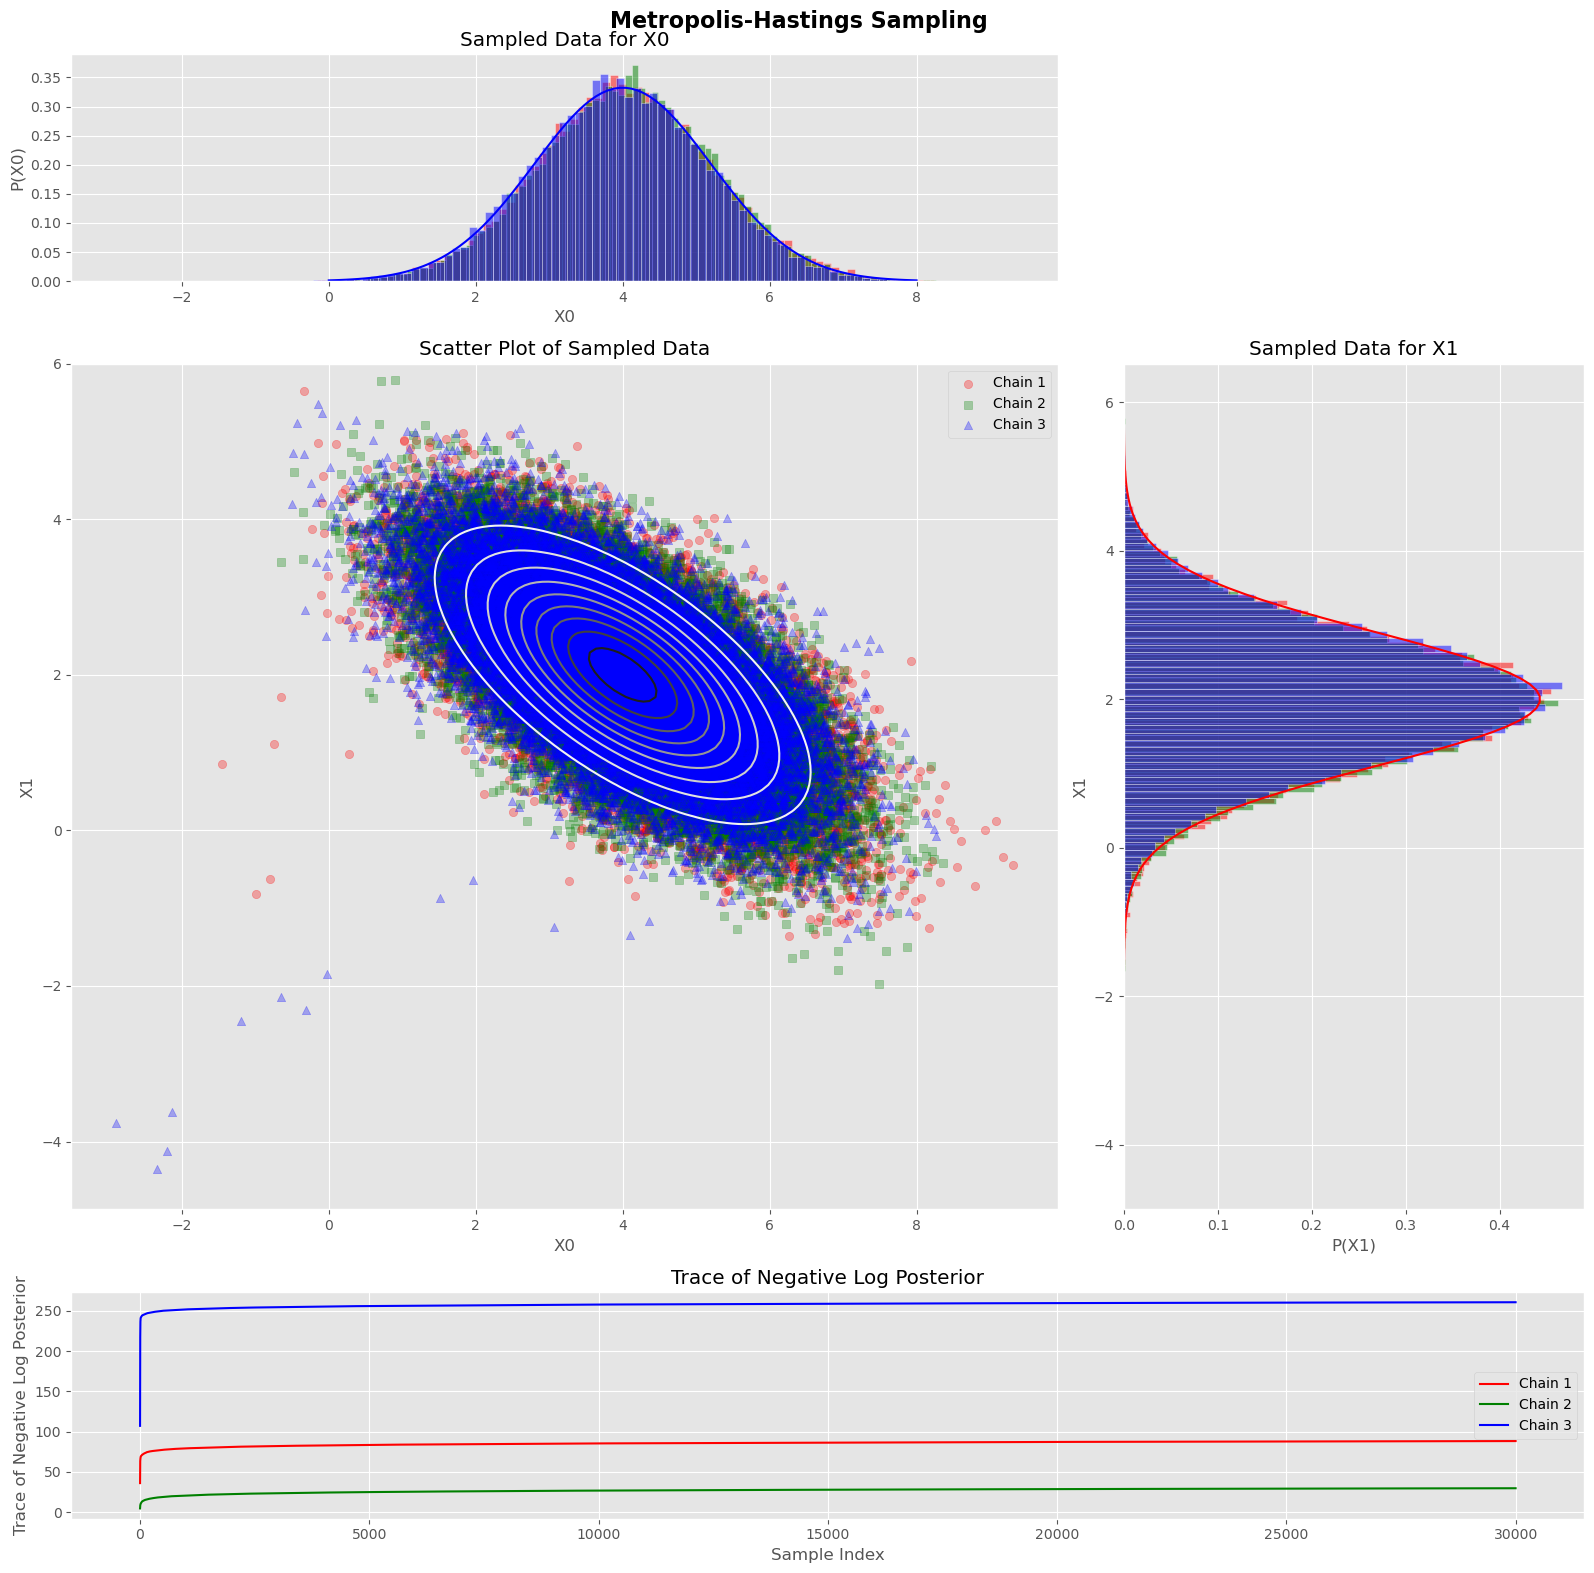

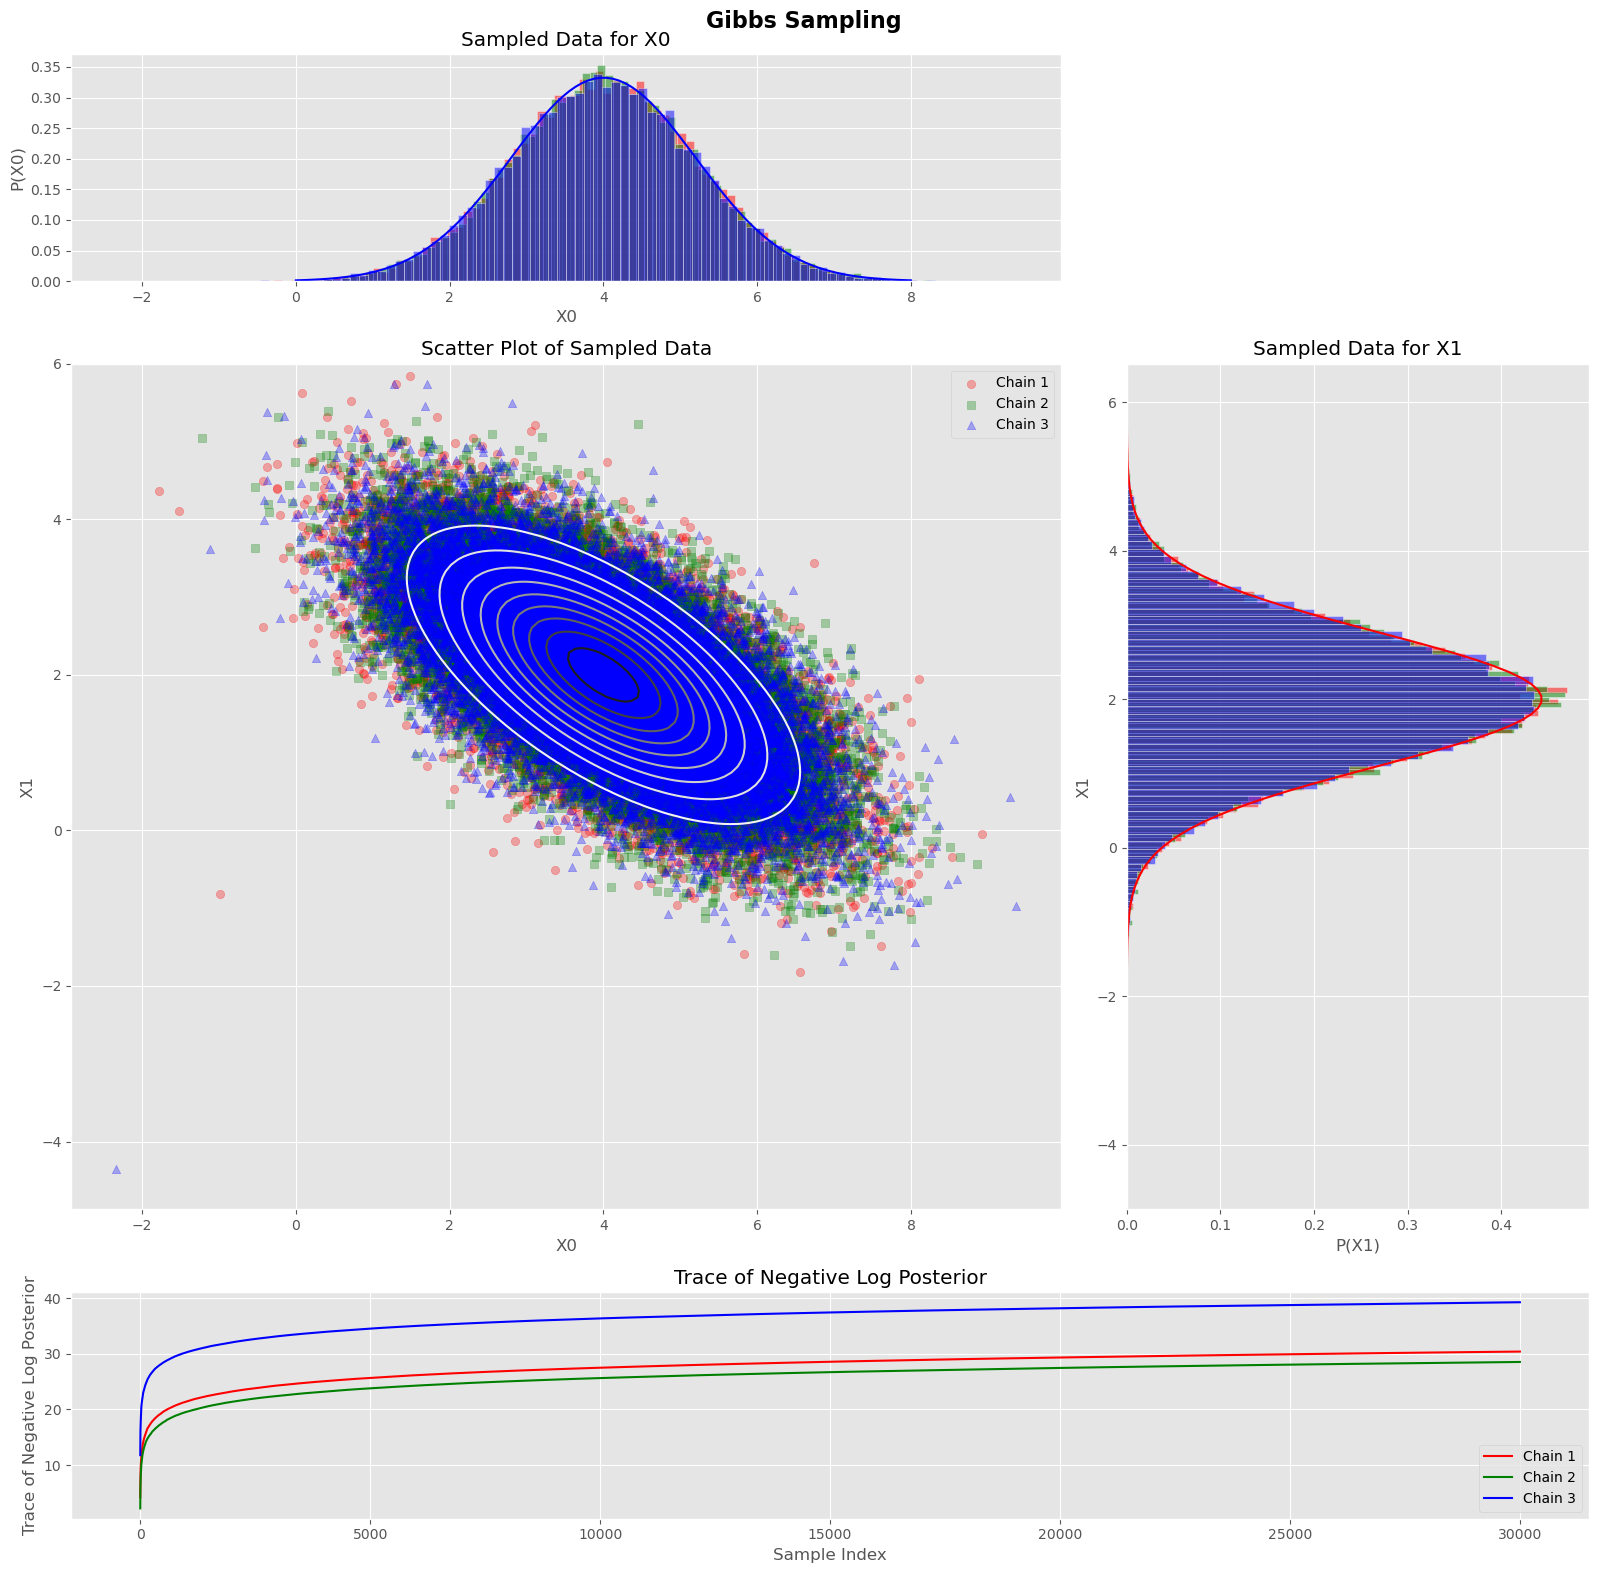

In [23]:
plot_samples_chains(mh_samples_list, mh_trace_list, "Metropolis-Hastings Sampling", markers=['o', 's', '^'], colors=['r', 'g', 'b'])
plot_samples_chains(gibbs_samples_list, gibbs_trace_list, "Gibbs Sampling", markers=['o', 's', '^'], colors=['r', 'g', 'b'])